# 短指令辨識

## 載入相關套件

In [1]:
# 載入相關套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import pathlib
import csv

In [2]:
# 不顯示警告訊息
import warnings
warnings.filterwarnings('ignore')

## 載入檔案

In [3]:
# 載入npy檔案
train_audio_path2 = './GoogleSpeechCommandsDataset/'
npy_files = [f for f in os.listdir(train_audio_path2) if f.endswith('.npy')]
print(npy_files)
all_wave = []
y = []
no=0
for i, label in enumerate(npy_files):
    class_wave = np.load(train_audio_path2+label)
    all_wave.append(class_wave)
    print(class_wave.shape)
    no+=class_wave.shape[0]
    y.extend(np.full(class_wave.shape[0], i))   

['bed.npy', 'cat.npy', 'happy.npy']
(1713, 16000)
(1733, 16000)
(1742, 16000)


In [4]:
# 計算 MFCC
MFCC_COUNT = 40
X = None
for class_wave in all_wave:
    for data in class_wave:
        mfcc = librosa.feature.mfcc(y=data, sr=len(data), n_mfcc=MFCC_COUNT)
        # print(data.shape, mfcc.shape)
        if X is None:
            X = mfcc.reshape(1, MFCC_COUNT, -1, 1)
        else:
            X = np.concatenate((X, mfcc.reshape(1, MFCC_COUNT, -1, 1)), axis=0)
    # print(X.shape) 
print(X.shape, len(y))

(5188, 40, 32, 1) 5188


In [42]:
# 資料切割
from sklearn.model_selection import train_test_split
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train.shape, X_test.shape

((4150, 40, 32, 1), (1038, 40, 32, 1))

In [44]:
# X_train = X_train.squeeze()
# X_test = X_test.squeeze()
# X_train = X_train.mean(axis=2)
# X_test = X_test.mean(axis=2)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((4150, 1280), (1038, 1280))

In [46]:
# SVM 模型
from sklearn.svm import SVC
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

model = SVC(probability=True)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9344894026974951

In [47]:
# 取得子目錄名稱
train_audio_path = './GoogleSpeechCommandsDataset/data/'
labels=os.listdir(train_audio_path)
labels

['bed', 'cat', 'happy']

In [80]:
# 預測函數
TOTAL_FRAME_COUNT = 16000 # 每個檔案統一的幀數
def predict(file_path):
    samples, sr = librosa.load(file_path, sr=None, res_type='kaiser_fast')
    # 繪製波形
    librosa.display.waveplot(samples, sr)
    plt.show()
    
    # 右邊補 0
    if len(samples) < TOTAL_FRAME_COUNT : 
        samples = np.pad(samples,(0, TOTAL_FRAME_COUNT-len(samples)),'constant')
    elif len(samples) > TOTAL_FRAME_COUNT : 
        # 取中間一段
        oversize = len(samples) - TOTAL_FRAME_COUNT
        samples = samples[int(oversize/2):int(oversize/2)+TOTAL_FRAME_COUNT]

    # 繪製波形
#     librosa.display.waveplot(samples, sr)
#     plt.show()

    # 驗證 mfcc 是否需要標準化
    mfcc = librosa.feature.mfcc(y=samples, sr=sr, n_mfcc=MFCC_COUNT)
#     for i in range(mfcc.shape[1]):
#         plt.scatter(x=range(mfcc.shape[0]), y=mfcc[:, i].reshape(-1))
    X_pred = mfcc.reshape(1, mfcc.shape[0]*mfcc.shape[1])
    # print(X_pred.shape)
    X_pred = pca.transform(X_pred)
    
    # 預測
    prob = model.predict_proba(X_pred)
    return np.around(prob, 2), labels[np.argmax(prob)]

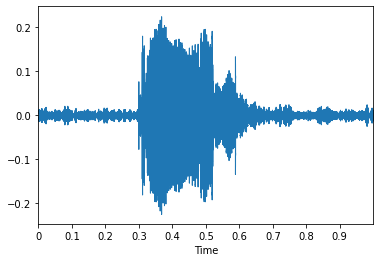

(array([[0.88, 0.03, 0.1 ]]), 'bed')

In [81]:
# 任選一檔案測試，該檔案發音為 bed
train_audio_path = './GoogleSpeechCommandsDataset/data/'
predict(train_audio_path+'bed/0d2bcf9d_nohash_0.wav')

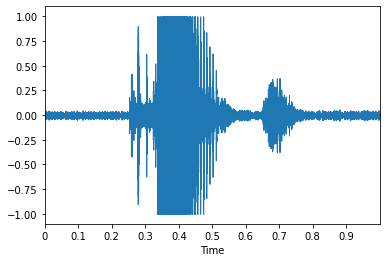

(array([[0.01, 0.93, 0.07]]), 'cat')

In [82]:
# 任選一檔案測試，該檔案發音為 cat
predict(train_audio_path+'cat/0ac15fe9_nohash_0.wav')

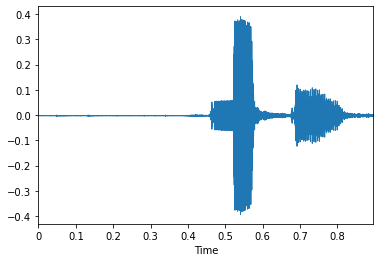

(array([[0.03, 0.01, 0.95]]), 'happy')

In [83]:
# 任選一檔案測試，該檔案發音為 happy
predict(train_audio_path+'happy/0ab3b47d_nohash_0.wav')

## 自行使用 14_10_record.py 錄音，指令：
python 14_10_record.py GoogleSpeechCommandsDataset/happy2.wav

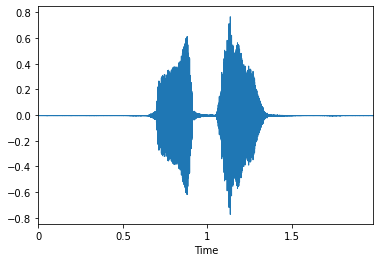

(array([[0.18, 0.19, 0.62]]), 'happy')

In [84]:
# 測試，該檔案發音為 happy
predict('./GoogleSpeechCommandsDataset/happy.wav')

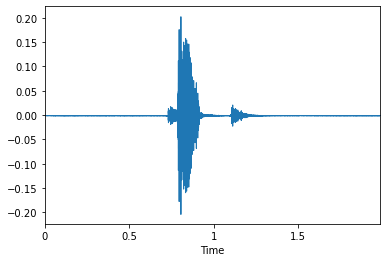

(array([[0.08, 0.91, 0.02]]), 'cat')

In [85]:
# 測試，該檔案發音為 cat
predict('./GoogleSpeechCommandsDataset/cat.wav')

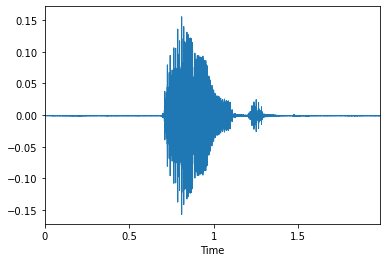

(array([[0.15, 0.  , 0.85]]), 'happy')

In [86]:
# 測試，該檔案發音為 bed
predict('./GoogleSpeechCommandsDataset/bed.wav')